# Imports

In [1]:
import pandas as pd
import warnings
from lifelines import CoxPHFitter, CoxTimeVaryingFitter
import re
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, TargetEncoder
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('../data/df_ph.csv',sep = ',')

# Encoding

In [3]:
df['Motif'] = df['Motif'].apply(lambda x : 3 if x == 'Motif tres mauvais' else 2 if x == 'Motif mauvais' else 1)

df['Situation_fam'] = df['Situation_fam'].apply(lambda x : 2 if x == 'Mauvaise situation' else 1)

df['Nature'] = df['Nature'].apply(lambda x : 2 if x == 'Mauvaise nature' else 1)

df['Solution_echec'] = df['Solution_echec'].apply(lambda x : 2 if x == 'Mauvaise solution' else 1)

df['Nature_op'] = df['Nature_op'].apply(lambda x : 2 if x == 'Mauvaise nature' else 1)

df['CD_MTF_ENE_CTX'] = df['MTF'].apply(lambda x : 2 if x == 'Mauvais MTF' else 1)

df['ETAT_CIVIL'] = df['ETAT_CIVIL'].apply(lambda x : 2 if x == 'Mauvais etat' else 1)

df['CSP'] = df['CSP'].apply(lambda x : 2 if x == 'Mauvaise CSP' else 1)

df['MTF'] = df['MTF'].apply(lambda x : 2 if x == 'Mauvais MTF' else 1)

df['nb_empr_ope'] = df['nb_empr_ope'].apply(lambda x : 1 if x == 'Un emprunteur' else 2)

df['ANC_PRO_MAX_PFI_2'] = df['ANC_PRO_MAX_PFI_2'].apply(lambda x : 1 if x == '(-inf, 30.50)' else 2 if x == '[30.50, 68.50)' else 3 if x == '[68.50, 151.50)' else 4)

df['MT_REST_VIVRE'] = df['MT_REST_VIVRE'].apply(lambda x : 1 if x == '[2418.50, inf)' else 2 )

df['CP'] = df['CP'].apply(lambda x : 3 if x == 'CP tres mauvais' else 2 if x == 'CP mauvais' else 1)

# Feature selection

In [4]:
liste_var = list(set(['Motif', 'MT_EAD_DNE_CHR_d', 'niv_gravite_mtf_dfs',
       'MTF', 'MT_REV_PFI', 'MT_FMG',
       'ANC_PRO_MAX_PFI', 'EAD_1an_avant_def', 'CP',
       'CD_DNE_CHR_LGD_SAIN', 'max_age_ctx', 'TX_APPOR','DET', 'arrete', 'cd_op','date_entree_defaut','MTF', 'dls_mep_entree_def','ANC_PRO_MAX_PFI_2','nb_empr_ope','MT_REST_VIVRE','DET', 'arrete', 'cd_op','date_entree_defaut','DT_MEP_OPE'])) # rajouter 
df = df[liste_var]

df = df[['MT_EAD_DNE_CHR_d',
       'DT_MEP_OPE', 'MTF', 'MT_REV_PFI', 'fam_PCD', 'MT_FMG',
       'ANC_PRO_MAX_PFI', 'EAD_1an_avant_def', 'CD_POST_BIEN_PFI',
        'max_age_ctx', 'TX_APPOR','DET', 'arrete', 'cd_op','date_entree_defaut','nb_empr_ope','dls_mep_entree_def','CD_MTF_ENE_CTX']]

In [5]:
df.select_dtypes(include = 'float').columns

Index(['MT_FMG', 'dls_mep_entree_def', 'MT_EAD_DNE_CHR_d', 'MT_REV_PFI',
       'TX_APPOR', 'CD_DNE_CHR_LGD_SAIN', 'ANC_PRO_MAX_PFI', 'max_age_ctx',
       'EAD_1an_avant_def'],
      dtype='object')

In [6]:
df['arrete'] = pd.to_datetime(df['arrete']) 
df['date_entree_defaut'] = pd.to_datetime(df['date_entree_defaut']) 

# Train validation split

In [7]:
df_validation = df[df['arrete']>"2020-12-30"]

In [8]:
data = df[df['arrete']<"2020-12-30"]

# Data prep for cox model

In [9]:
data_haz = data.copy()
data_test =df_validation.copy()

In [10]:
data_haz['start'] = 0
data_haz['stop'] = data_haz['arrete'] - data_haz['date_entree_defaut']
data_haz['stop'] = data_haz['stop'].dt.days

data_test['start'] = 0
data_test['stop'] = data_test['arrete'] - data_test['date_entree_defaut']
data_test['stop'] = data_test['stop'].dt.days

In [11]:
data_haz['id'] = data_haz['cd_op'].apply(lambda x: re.sub(r'\D', '', str(x)))


data_test['id'] = data_test['cd_op'].apply(lambda x: re.sub(r'\D', '', str(x)))

In [12]:
data_haz.id = data_haz.id.astype('int')

In [13]:
data_haz.loc[(data_haz['start'] == data_haz['stop']) & (data_haz['start'] == 0) & data_haz[
    'DET'], 'stop'] = 0.5  # car le modele n'accepte pas les individus qui sortent de la survie au moment ou ils y entrent donc on remplace les 0 par 0.5.

data_test.loc[(data_test['start'] == data_test['stop']) & (data_test['start'] == 0) & data_test[
    'DET'], 'stop'] = 0.5 

In [14]:
data_haz = data_haz.select_dtypes(exclude=["datetime64"])

data_test = data_test.select_dtypes(exclude=["datetime64"])

In [15]:
data_haz.drop(columns = ["cd_op"], inplace = True)


data_test.drop(columns = ["cd_op"], inplace = True)

In [16]:
data_haz.shape

(12461, 21)

In [17]:
data_haz.columns

Index(['DET', 'MT_FMG', 'dls_mep_entree_def', 'CP', 'MT_EAD_DNE_CHR_d',
       'MT_REV_PFI', 'MTF', 'niv_gravite_mtf_dfs', 'ANC_PRO_MAX_PFI_2',
       'TX_APPOR', 'CD_DNE_CHR_LGD_SAIN', 'ANC_PRO_MAX_PFI', 'Motif',
       'max_age_ctx', 'nb_empr_ope', 'MT_REST_VIVRE', 'DT_MEP_OPE',
       'EAD_1an_avant_def', 'start', 'stop', 'id'],
      dtype='object')

# Modelisation

In [18]:
data_test.drop(columns = ['start','DET', 'id'],inplace = True )

In [19]:
from lifelines import CoxPHFitter

cph = CoxPHFitter(penalizer=0.1)  # Choisir le paramètre de pénalité
cph.fit(data_haz.drop(columns = ['id','start']), duration_col='stop', event_col='DET')


<lifelines.CoxPHFitter: fitted with 12461 total observations, 7617 right-censored observations>

In [20]:
cph.check_assumptions(data_haz.drop(columns = ['id','start']))

The ``p_value_threshold`` is set at 0.01. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.


<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 12461 total observations, 7617 right-censored observations>
         test_name = proportional_hazard_test

---
                          test_statistic      p  -log2(p)
ANC_PRO_MAX_PFI     km              0.60   0.44      1.19
                    rank            0.52   0.47      1.09
ANC_PRO_MAX_PFI_2   km              0.14   0.71      0.50
                    rank            0.21   0.65      0.63
CD_DNE_CHR_LGD_SAIN km              6.25   0.01      6.33
                    rank            9.89 <0.005      9.23
CP                  km              4.01   0.05      4.47
                    rank            2.95   0.09      3.54
DT_MEP_OPE          km              1.24   0.27      1.91
                    rank            1.49   0.22      2.17
EAD_1an_avant_def   km              0.07   0.79      0.34
                    rank            0.24   0.62      0.68
MTF                 km              2.79   0.09      3.40
                    rank            2.64   0.10      3.26
MT_EAD_DNE_CHR_d    km              0.04   0.85      0.24
                    rank            0.00   0.96      0.06
MT_FMG              km              0.28   0.59      0.75
                    rank            0.34   0.56      0.83
MT_REST_VIVRE       km              2.00   0.16      2.67
                    rank            1.34   0.25      2.01
MT_REV_PFI          km              2.49   0.11      3.12
                    rank            4.45   0.03      4.84
Motif               km             18.11 <0.005     15.55
                    rank           19.81 <0.005     16.84
TX_APPOR            km              1.25   0.26      1.93
                    rank            1.19   0.27      1.86
dls_mep_entree_def  km              0.00   0.95      0.07
                    rank            0.01   0.93      0.11
max_age_ctx         km              3.61   0.06      4.13
                    rank            5.16   0.02      5.43
nb_empr_ope         km              0.45   0.50      1.00
                    rank            0.52   0.47      1.09
niv_gravite_mtf_dfs km             14.00 <0.005     12.41
                    rank           14.04 <0.005     12.45



1. Variable 'niv_gravite_mtf_dfs' failed the non-proportional test: p-value is 0.0002.

   Advice: with so few unique values (only 2), you can include `strata=['niv_gravite_mtf_dfs', ...]`
in the call in `.fit`. See documentation in link [E] below.

2. Variable 'CD_DNE_CHR_LGD_SAIN' failed the non-proportional test: p-value is 0.0017.

   Advice: with so few unique values (only 5), you can include `strata=['CD_DNE_CHR_LGD_SAIN', ...]`
in the call in `.fit`. See documentation in link [E] below.

3. Variable 'Motif' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few unique values (only 3), you can include `strata=['Motif', ...]` in the call
in `.fit`. See documentation in link [E] below.

---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-stratify-on-it
[C]  https://lifelines.readt

[]

In [21]:
cph.AIC_partial_

78641.45943140531

In [22]:
cph.concordance_index_

0.7273528622150571

In [23]:
df.shape

(22693, 21)

In [24]:
data_haz.columns

Index(['DET', 'MT_FMG', 'dls_mep_entree_def', 'CP', 'MT_EAD_DNE_CHR_d',
       'MT_REV_PFI', 'MTF', 'niv_gravite_mtf_dfs', 'ANC_PRO_MAX_PFI_2',
       'TX_APPOR', 'CD_DNE_CHR_LGD_SAIN', 'ANC_PRO_MAX_PFI', 'Motif',
       'max_age_ctx', 'nb_empr_ope', 'MT_REST_VIVRE', 'DT_MEP_OPE',
       'EAD_1an_avant_def', 'start', 'stop', 'id'],
      dtype='object')

<Axes: >

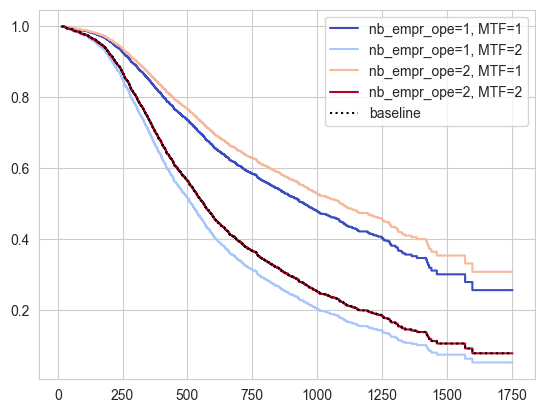

In [25]:
cph.plot_partial_effects_on_outcome(['nb_empr_ope','MTF'], values=[ [1,  1], [1,  2], [2, 1], [2,  2]], cmap='coolwarm')

In [26]:
data_haz.nunique()

DET                        2
MT_FMG                  7454
dls_mep_entree_def      4751
CP                         3
MT_EAD_DNE_CHR_d       12448
MT_REV_PFI              8954
MTF                        2
niv_gravite_mtf_dfs        2
ANC_PRO_MAX_PFI_2          4
TX_APPOR                 156
CD_DNE_CHR_LGD_SAIN        5
ANC_PRO_MAX_PFI          479
Motif                      3
max_age_ctx            11678
nb_empr_ope                2
MT_REST_VIVRE              2
DT_MEP_OPE              4927
EAD_1an_avant_def      12441
start                      1
stop                    1146
id                     12461
dtype: int64

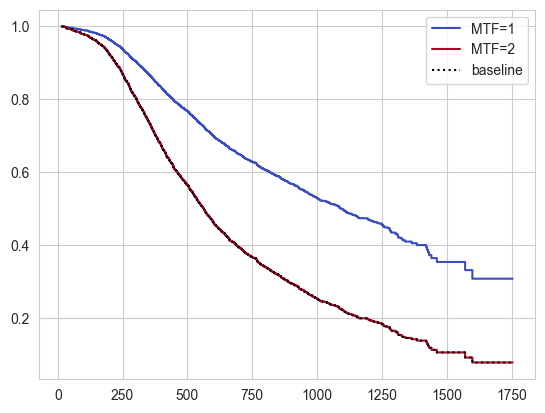

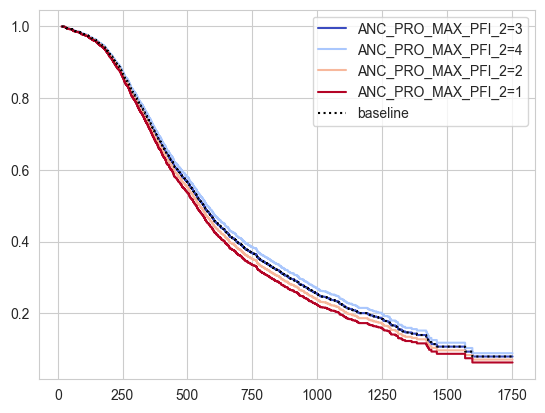

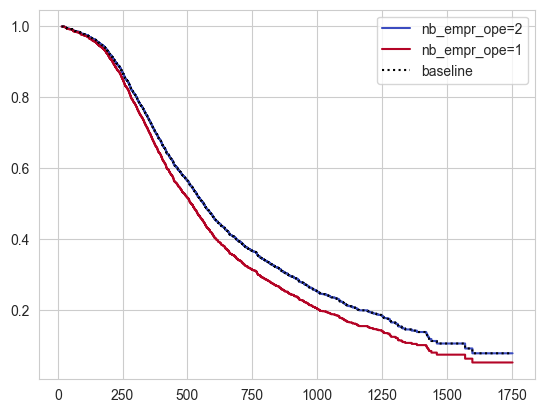

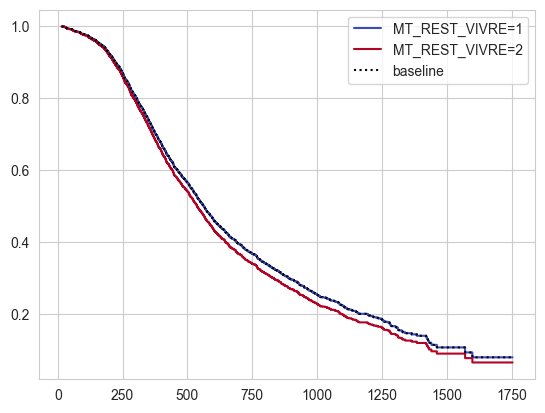

In [27]:
for col in data_haz[['MTF','ANC_PRO_MAX_PFI_2','nb_empr_ope','MT_REST_VIVRE']].columns:
    cph.plot_partial_effects_on_outcome(col, values=data_haz[col].unique(), cmap='coolwarm')

<Axes: >

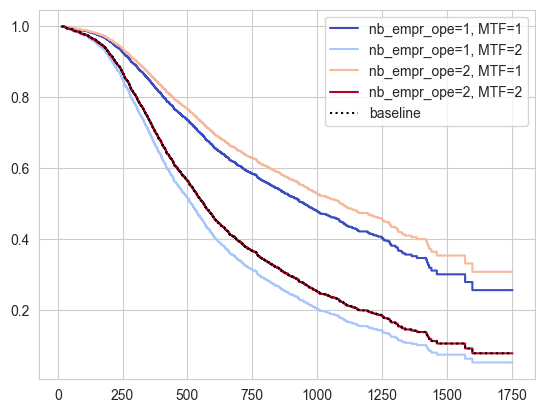

In [28]:
cph.plot_partial_effects_on_outcome(['nb_empr_ope','MTF'], values=[ [1,  1], [1,  2], [2, 1], [2,  2]], cmap='coolwarm')

In [29]:
data_haz.columns

Index(['DET', 'MT_FMG', 'dls_mep_entree_def', 'CP', 'MT_EAD_DNE_CHR_d',
       'MT_REV_PFI', 'MTF', 'niv_gravite_mtf_dfs', 'ANC_PRO_MAX_PFI_2',
       'TX_APPOR', 'CD_DNE_CHR_LGD_SAIN', 'ANC_PRO_MAX_PFI', 'Motif',
       'max_age_ctx', 'nb_empr_ope', 'MT_REST_VIVRE', 'DT_MEP_OPE',
       'EAD_1an_avant_def', 'start', 'stop', 'id'],
      dtype='object')

In [30]:
cph.confidence_intervals_

,95% lower-bound,95% upper-bound
covariate,,
MT_FMG,-2.596484e-05,4.029280e-05
dls_mep_entree_def,4.480483e-03,6.270812e-03
CP,3.328161e-01,3.936675e-01
MT_EAD_DNE_CHR_d,-2.792789e-07,4.814447e-07
MT_REV_PFI,-4.886148e-07,-1.913090e-08
MTF,6.335435e-01,9.044094e-01
niv_gravite_mtf_dfs,3.151922e-01,4.352311e-01
ANC_PRO_MAX_PFI_2,-7.659679e-02,-1.237845e-02
TX_APPOR,-2.951435e-02,4.328692e-02


# Predictions

In [31]:
cph.predict_partial_hazard(data_test)

37       0.183363
40       0.749575
42       0.564698
50       0.750655
64       0.327603
           ...   
22688    1.021239
22689    0.509665
22690    0.605623
22691    0.753186
22692    0.266222
Length: 10232, dtype: float64

In [32]:
cph.predict_expectation(data_test)

37       1425.045803
40        865.038245
42        999.914890
50        864.347954
64       1234.861225
            ...     
22688     719.010655
22689    1047.379605
22690     966.970874
22691     862.732865
22692    1310.622872
Length: 10232, dtype: float64

In [33]:
pred = cph.predict_survival_function(data_test)

In [34]:
pred = pred.transpose()

verification manuelle des predictions

In [35]:
df_validation

,DET,MT_FMG,dls_mep_entree_def,CP,cd_op,MT_EAD_DNE_CHR_d,MT_REV_PFI,MTF,niv_gravite_mtf_dfs,ANC_PRO_MAX_PFI_2,...,CD_DNE_CHR_LGD_SAIN,date_entree_defaut,ANC_PRO_MAX_PFI,Motif,max_age_ctx,nb_empr_ope,MT_REST_VIVRE,DT_MEP_OPE,EAD_1an_avant_def,arrete
37,0,1046.41,241.866667,2,I990802466,1311.87,22715.0,1,0,3,...,9.0,2019-10-15,72.0,1,370.461111,2,1,8429,6181.79,2022-12-31
40,0,1878.17,235.366667,1,I990906121,12803.41,48570.0,2,1,4,...,9.0,2019-03-19,179.0,2,497.791667,2,1,7865,3066.75,2021-05-31
42,0,2347.71,205.666667,1,I991041870,4183.77,66408.0,2,1,4,...,9.0,2016-10-31,155.0,2,533.294444,2,1,8422,4183.77,2022-12-31
50,0,1195.20,242.233333,2,M000106044,9378.88,20582.0,1,0,1,...,9.0,2020-05-15,10.0,3,488.627778,2,1,7587,8304.58,2021-03-31
64,0,1074.77,241.433333,1,M000542503,11074.89,41400.0,2,0,3,...,1.0,2020-08-07,126.0,1,586.441667,2,1,7753,12918.42,2021-11-30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22688,0,1494.81,4.600000,3,M220200817,143256.11,66960.0,2,0,4,...,2.0,2022-06-09,154.0,1,651.602778,2,1,254,143614.00,2022-12-31
22689,0,4108.26,0.000000,1,M220207473,441508.00,143412.0,2,0,3,...,2.0,2022-04-26,79.0,1,444.225000,2,1,127,441508.00,2022-08-31
22690,0,3493.56,0.000000,1,M220330795,372182.00,71652.0,2,0,2,...,2.0,2021-08-04,61.0,1,594.061111,2,2,53,372182.00,2022-05-31
22691,0,675.00,0.000000,2,M220505830,50840.00,38846.0,2,0,4,...,2.0,2022-06-16,181.0,1,647.116667,2,2,198,50840.00,2022-12-31


In [36]:
indiv_1 = df_validation.iloc[15,:]
indiv_1= pd.DataFrame(indiv_1)
indiv_1 = indiv_1.transpose()
indiv_1[['cd_op','DET','Motif', 'MT_EAD_DNE_CHR_d', 'niv_gravite_mtf_dfs', 'MTF',
        'MT_REV_PFI', 'MT_FMG', 'EAD_1an_avant_def',
       'ANC_PRO_MAX_PFI', 'TX_APPOR', 'max_age_ctx', 'CP',
       'CD_DNE_CHR_LGD_SAIN']]

,cd_op,DET,Motif,MT_EAD_DNE_CHR_d,niv_gravite_mtf_dfs,MTF,MT_REV_PFI,MT_FMG,EAD_1an_avant_def,ANC_PRO_MAX_PFI,TX_APPOR,max_age_ctx,CP,CD_DNE_CHR_LGD_SAIN
124,M010347006,1,2,7301.82,1,2,40428.0,1061.04,10195.06,57.0,0.4,486.755556,3,9.0


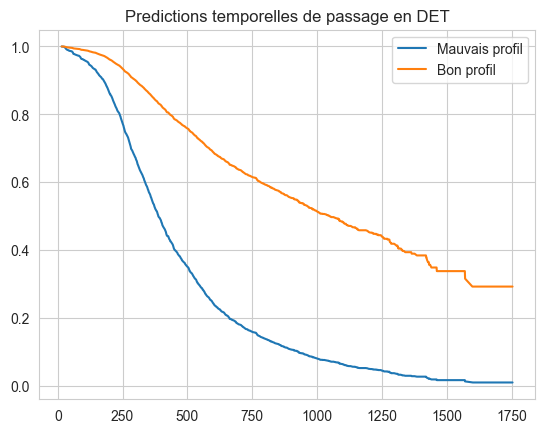

In [37]:
survival_function_observation_15 = pred.iloc[15]
survival_function_observation_20 = pred.iloc[20]
# Tracer la fonction de survie pour l'observation 0
plt.plot(survival_function_observation_15, label='Mauvais profil')
plt.plot(survival_function_observation_20, label='Bon profil')

plt.title("Predictions temporelles de passage en DET")
plt.legend()
plt.show()

### Idee : Realiser 2 cas fictifs et montrer leurs previsions : un individu avec un bon dossier --> le modele devra predire une sortie de defaut, et un individu avec un mauvais dossier --> le modèle devra predire un det 